# Blade Element Momentum model

This is an example of implementation of a Blade Element Momentum model for application to an horizontal axis wind turbine and propeller:
1. in steady, uniform, axial flow.
2. implementing corrections for heavily loaded streamtubes.
3. implementing corrections for finite number of blades in a finite tip speed ratio.

## Tutorial support
In the *iframe* below, you can find the tutorial available at https://csimaoferreira.github.io/Rotor-Wake-Aerodynamics-BEM/#/

In [97]:
from IPython.display import IFrame

In [98]:
IFrame(src='https://csimaoferreira.github.io/Rotor-Wake-Aerodynamics-BEM/#/', width=1000, height=600)

## Definition of required functions

In [99]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np  

In [100]:
def CTfunction(a):
    """Calculate thrust coefficient for propellers (accelerating flow, a < 0)"""
    CT = -4 * a * (1 + a)  # Propeller thrust coefficient formula
    return CT
    

def ainduction_propeller(CT):
    # Valid for all CT (including CT > 1)
    return 0.5 * (np.sqrt(1 + CT) - 1) if CT <= 1 else -0.5

In [101]:
def PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, axial_induction):
    """
    This function calcualte steh combined tip and root Prandtl correction at agiven radial position 'r_R' (non-dimensioned by rotor radius), 
    given a root and tip radius (also non-dimensioned), a tip speed ratio TSR, the number lf blades NBlades and the axial induction factor
    """
    temp1 = -NBlades/2*(tipradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Ftip = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades/2*(rootradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Froot = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot*Ftip, Ftip, Froot


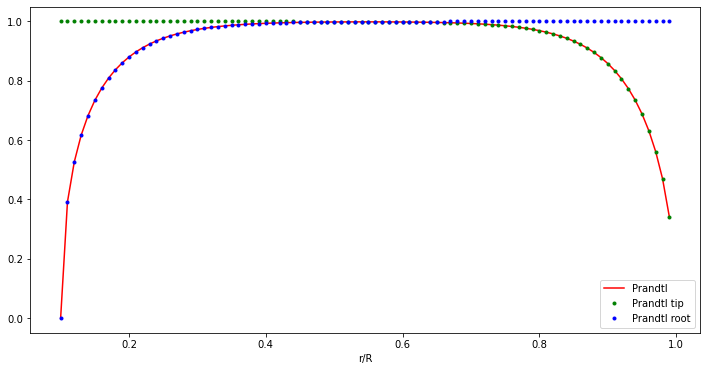

In [102]:
# plot Prandtl tip, root and combined correction for a number of blades and induction 'a', over the non-dimensioned radius
r_R = np.arange(0.1, 1, .01)
a = np.zeros(np.shape(r_R))+0.3
Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, 0.1, 1, 7, 3, a)

fig1 = plt.figure(figsize=(12, 6))
plt.plot(r_R, Prandtl, 'r-', label='Prandtl')
plt.plot(r_R, Prandtltip, 'g.', label='Prandtl tip')
plt.plot(r_R, Prandtlroot, 'b.', label='Prandtl root')
plt.xlabel('r/R')
plt.legend()
plt.show()




In [103]:
import pandas as pd

airfoil = 'ARAD8pct_polar.txt'

# Try reading with space or tab as a delimiter
data1 = pd.read_csv(airfoil, delim_whitespace=True, header=0, names=["AOA", "cl", "cd", "cm"])

# Extracting data columns
polar_alpha = data1['AOA']
polar_cl = data1['cl']
polar_cd = data1['cd']
polar_cm = data1["cm"]


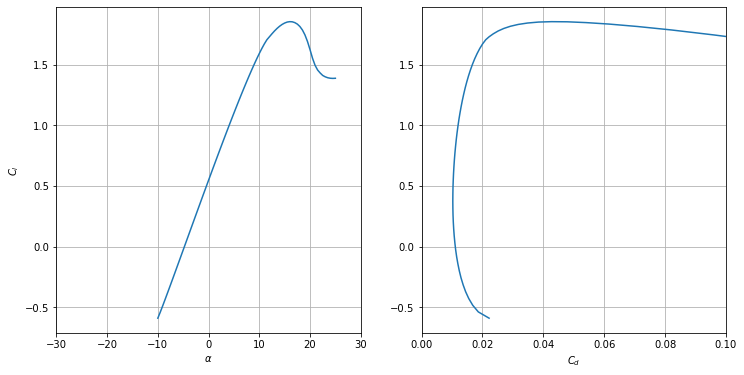

In [104]:
# plot polars of the airfoil C-alfa and Cl-Cd

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(polar_alpha, polar_cl)
axs[0].set_xlim([-30,30])
axs[0].set_xlabel(r'$\alpha$')
axs[0].set_ylabel(r'$C_l$')
axs[0].grid()
axs[1].plot(polar_cd, polar_cl)
axs[1].set_xlim([0,.1])
axs[1].set_xlabel(r'$C_d$')
axs[1].grid()
plt.show()

In [105]:
def loadBladeElement(vnorm, vtan, r_R, chord, twist, polar_alpha, polar_cl, polar_cd):
    """
    calculates the load in the blade element
    """
    vmag2 = vnorm**2 + vtan**2
    inflowangle = np.arctan2(vnorm, vtan)
    alpha_deg = twist + np.degrees(inflowangle)
    alpha_rad = np.radians(alpha_deg)
    
    cl = np.interp(alpha_deg, polar_alpha, polar_cl)
    cd = np.interp(alpha_deg, polar_alpha, polar_cd)
    
    lift = 0.5 * vmag2 * cl * chord
    drag = 0.5 * vmag2 * cd * chord
    
    # Blade-normal force
    blade_normal_force = lift * np.cos(alpha_rad) + drag * np.sin(alpha_rad)
    
    # Axial and tangential forces
    fnorm = lift * np.cos(inflowangle) + drag * np.sin(inflowangle)
    ftan = lift * np.sin(inflowangle) - drag * np.cos(inflowangle)
    
    # Circulation (gamma) calculation - THIS WAS MISSING
    gamma = 0.5 * np.sqrt(vmag2) * cl * chord  # <-- ADD THIS LINE
    
    return fnorm, ftan, gamma, blade_normal_force
def solveStreamtube(Uinf, r1_R, r2_R, rootradius_R, tipradius_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd ):
    """
    solve balance of momentum between blade element load and loading in the streamtube
    input variables:
    Uinf - wind speed at infinity
    r1_R,r2_R - edges of blade element, in fraction of Radius ;
    rootradius_R, tipradius_R - location of blade root and tip, in fraction of Radius ;
    Radius is the rotor radius
    Omega -rotational velocity
    NBlades - number of blades in rotor
    """
    Area = np.pi*((r2_R*Radius)**2-(r1_R*Radius)**2) #  area streamtube
    r_R = (r1_R+r2_R)/2 # centroide
    # initiatlize variables
    a = 0.0 # axial induction
    aline = 0.0 # tangential induction factor
    
    Niterations = 100
    Erroriterations =0.00001 # error limit for iteration rpocess, in absolute value of induction
    
    for i in range(Niterations):
        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate velocity and loads at blade element"
        # ///////////////////////////////////////////////////////////////////////
        Urotor = Uinf*(1-a) # axial velocity at rotor
        Utan = (1+aline)*Omega*r_R*Radius # tangential velocity at rotor
        # calculate loads in blade segment in 2D (N/m)
        fnorm, ftan, gamma, blade_normal_force = loadBladeElement(Urotor, Utan, r_R,chord, twist, polar_alpha, polar_cl, polar_cd)
        load3Daxial =fnorm*Radius*(r2_R-r1_R)*NBlades # 3D force in axial direction
        # load3Dtan =loads[1]*Radius*(r2_R-r1_R)*NBlades # 3D force in azimuthal/tangential direction (not used here)
      
        # ///////////////////////////////////////////////////////////////////////
        # //the block "Calculate velocity and loads at blade element" is done
        # ///////////////////////////////////////////////////////////////////////

        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        # // calculate thrust coefficient at the streamtube 
        CT = load3Daxial/(0.5*Area*Uinf**2)
        
        # calculate new axial induction, accounting for Glauert's correction
        anew =  ainduction_propeller(CT)
        
        # correct new axial induction with Prandtl's correction
        Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, Omega*Radius/Uinf, NBlades, anew);
        if (Prandtl < 0.0001): 
            Prandtl = 0.0001 # avoid divide by zero
        anew = anew/Prandtl # correct estimate of axial induction
        a = 0.75*a+0.25*anew # for improving convergence, weigh current and previous iteration of axial induction

        # calculate aximuthal induction
        aline = ftan*NBlades/(2*np.pi*Uinf*(1-a)*Omega*2*(r_R*Radius)**2)
        aline =aline/Prandtl # correct estimate of azimuthal induction with Prandtl's correction
        # ///////////////////////////////////////////////////////////////////////////
        # // end of the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        
        #// test convergence of solution, by checking convergence of axial induction
        if (np.abs(a-anew) < Erroriterations): 
            # print("iterations")
            # print(i)
            break

    return [a , aline, r_R, fnorm , ftan, gamma, blade_normal_force]

In [106]:
import numpy as np

# Define blade geometry

delta_r_R = 0.05  # Discretization step
hub_prop = 0.25  # r/R value where the blade starts
r_R = np.arange(hub_prop, 1 + delta_r_R / 2, delta_r_R)  # Discretized blade span

# Blade shape
pitch = 46  # degrees at r/R = 0.70
chord_distribution = 0.18 - 0.06 * r_R  # Chord distribution function (for r/R > 0.25)
twist_distribution = -50 * r_R + 35  # Twist distribution function (for r/R > 0.25)
# Define flow conditions
Radius = 0.7  # m
Uinf = 60  # m/s (unperturbed wind speed)
rpm = 1200  # Rotational speed
Omega = (rpm / 60) * 2 * np.pi # Angular velocity in rad/s
vtip = Omega * Radius  # Tip speed
TSR = vtip / Uinf  # Tip Speed Ratio
NBlades = 6  # Number of blades

TipLocation_R = 1
RootLocation_R = hub_prop

# Solve BEM model
results = np.zeros([len(r_R) - 1, 7])

for i in range(len(r_R) - 1):
    chord = np.interp((r_R[i] + r_R[i + 1]) / 2, r_R, chord_distribution)
    twist = np.interp((r_R[i] + r_R[i + 1]) / 2, r_R, twist_distribution)
    
    results[i, :] = solveStreamtube(Uinf, r_R[i], r_R[i + 1], RootLocation_R, TipLocation_R, Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd)


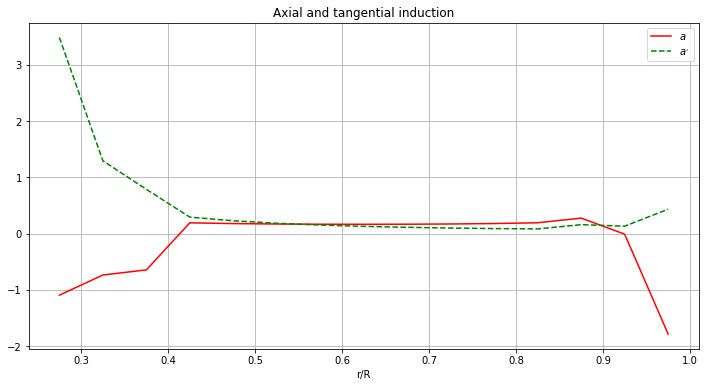

In [107]:


fig1 = plt.figure(figsize=(12, 6))
plt.title('Axial and tangential induction')
plt.plot(results[:,2], results[:,0], 'r-', label=r'$a$')
plt.plot(results[:,2], results[:,1], 'g--', label=r'$a^,$')
plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()

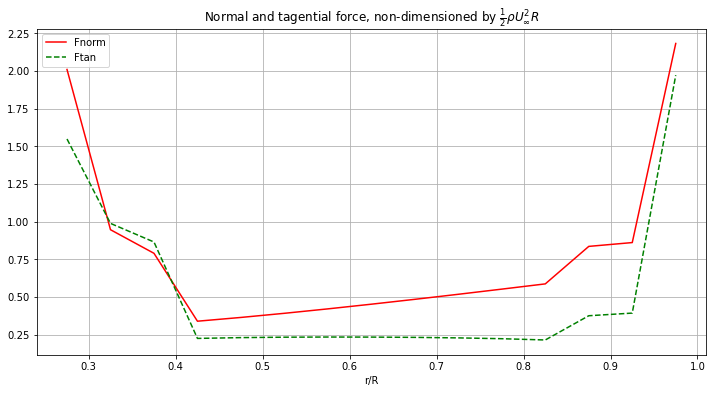

In [108]:
fig1 = plt.figure(figsize=(12, 6))
plt.title(r'Normal and tagential force, non-dimensioned by $\frac{1}{2} \rho U_\infty^2 R$')
plt.plot(results[:,2], results[:,3]/(0.5*Uinf**2*Radius), 'r-', label=r'Fnorm')
plt.plot(results[:,2], results[:,4]/(0.5*Uinf**2*Radius), 'g--', label=r'Ftan')
plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()

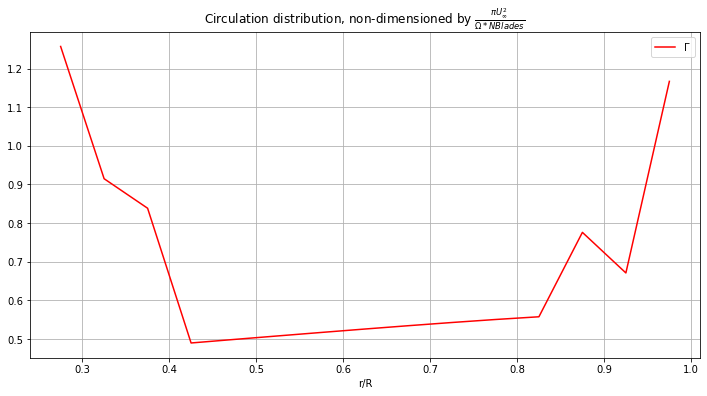

In [109]:
fig1 = plt.figure(figsize=(12, 6))
plt.title(r'Circulation distribution, non-dimensioned by $\frac{\pi U_\infty^2}{\Omega * NBlades } $')
plt.plot(results[:,2], results[:,5]/(np.pi*Uinf**2/(NBlades*Omega)), 'r-', label=r'$\Gamma$')
plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()

In [110]:
rho = 1  # Air density [kg/m³]
dr = delta_r_R * Radius  # Element width in meters


# Forces and moments
thrust = np.sum(results[:, 3] * dr * NBlades)
#torque = np.sum(results[:, 4] * results[:, 2] * Radius * dr * NBlades)
r_centroid = ((r_R[i] + r_R[i+1])/2) * Radius  # Physical radius [m]
torque = np.sum(results[:,4] * r_centroid * dr * NBlades)

power = torque * Omega
total_blade_normal_force = np.sum(results[:, 6] * dr * NBlades)

# Rotational parameters
n = rpm / 60  # Rotation frequency [Hz]
D = 2 * Radius
tip_speed = Omega * Radius

# Coefficients
CT = thrust / (rho * n**2 * D**4)
CP = power / (rho * n**3 * D**5)
CQ = torque / (rho * n**2 * D**5)

#total_blade_area = NBlades * np.sum(chord_distribution * dr)
Cn = total_blade_normal_force / (rho * n**2 * D**4)

print(f"CT: {CT:.4f} (Thrust Coefficient)")
print(f"CP: {CP:.4f} (Power Coefficient)")
print(f"CQ: {CQ:.4f} (Torque Coefficient)")
print(f"Cn: {Cn:.4f} (Blade Normal Force Coefficient)")


CT: 2.0219 (Thrust Coefficient)
CP: 4.3266 (Power Coefficient)
CQ: 0.6886 (Torque Coefficient)
Cn: 1.8510 (Blade Normal Force Coefficient)



=== Calculating J = 1.6 (Uinf = 44.8 m/s) ===

=== Calculating J = 2.0 (Uinf = 56.0 m/s) ===

=== Calculating J = 2.4 (Uinf = 67.2 m/s) ===


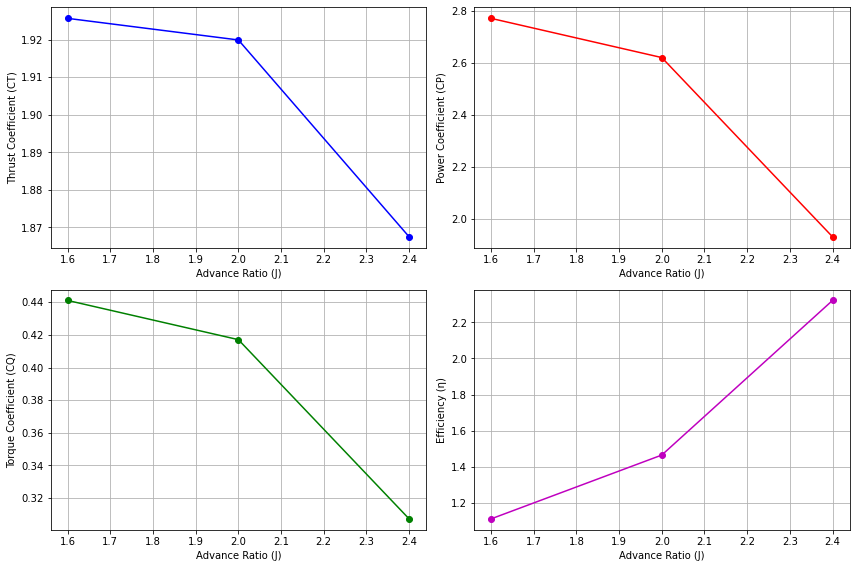

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters
RPM = 1200                # Constant rotational speed [rev/min]
Radius = 0.7              # Propeller radius [m]
D = 2 * Radius            # Propeller diameter [m]
rho = 1                   # Air density [kg/m³]
NBlades = 6               # Number of blades

# Blade geometry (unchanged)
delta_r_R = 0.05
hub_prop = 0.25
r_R = np.arange(hub_prop, 1 + delta_r_R/2, delta_r_R)
chord_distribution = 0.18 - 0.06 * r_R
twist_distribution = -50 * r_R + 35

# Target advance ratios
Js = np.array([1.6, 2.0, 2.4])

# Initialize arrays to store results
CTs = np.zeros_like(Js)
CPs = np.zeros_like(Js)
CQs = np.zeros_like(Js)
Cn = total_blade_normal_force / (rho * n**2 * D**4)
effs = np.zeros_like(Js)

# Constant rotational parameters
n = RPM/60               # Rotation frequency [Hz]
Omega = (RPM/60) * 2 * np.pi  # Angular velocity [rad/s]

for idx, J in enumerate(Js):
    # Calculate corresponding freestream velocity
    Uinf = J * n * D
    
    print(f"\n=== Calculating J = {J:.1f} (Uinf = {Uinf:.1f} m/s) ===")
    
    # Solve BEM model
    results = np.zeros([len(r_R)-1, 7])
    dr = delta_r_R * Radius
    
    for i in range(len(r_R)-1):
        chord = np.interp((r_R[i] + r_R[i+1])/2, r_R, chord_distribution)
        twist = np.interp((r_R[i] + r_R[i+1])/2, r_R, twist_distribution)
        
        results[i,:] = solveStreamtube(Uinf, r_R[i], r_R[i+1], hub_prop, 1,
                                      Omega, Radius, NBlades, chord, twist,
                                      polar_alpha, polar_cl, polar_cd)
    
    # Calculate forces and coefficients
    thrust = np.sum(results[:,3] * dr * NBlades)
    torque = np.sum(results[:,4] * results[:,2] * Radius * dr * NBlades)
    power = torque * Omega
    total_blade_normal_force = np.sum(results[:, 6] * dr * NBlades)

    
    # Dimensionless coefficients
    CT = thrust / (rho * n**2 * D**4)
    CP = power / (rho * n**3 * D**5)
    CQ = torque / (rho * n**2 * D**5)
    
    # Propeller efficiency
    eta = (CT * J) / CP if CP != 0 else 0
    
    # Store results
    CTs[idx] = CT
    CPs[idx] = CP
    CQs[idx] = CQ
    effs[idx] = eta

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(Js, CTs, 'bo-')
plt.xlabel('Advance Ratio (J)')
plt.ylabel('Thrust Coefficient (CT)')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Js, CPs, 'ro-')
plt.xlabel('Advance Ratio (J)')
plt.ylabel('Power Coefficient (CP)')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Js, CQs, 'go-')
plt.xlabel('Advance Ratio (J)')
plt.ylabel('Torque Coefficient (CQ)')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Js, effs, 'mo-')
plt.xlabel('Advance Ratio (J)')
plt.ylabel('Efficiency (η)')
plt.grid(True)

plt.tight_layout()
plt.show()

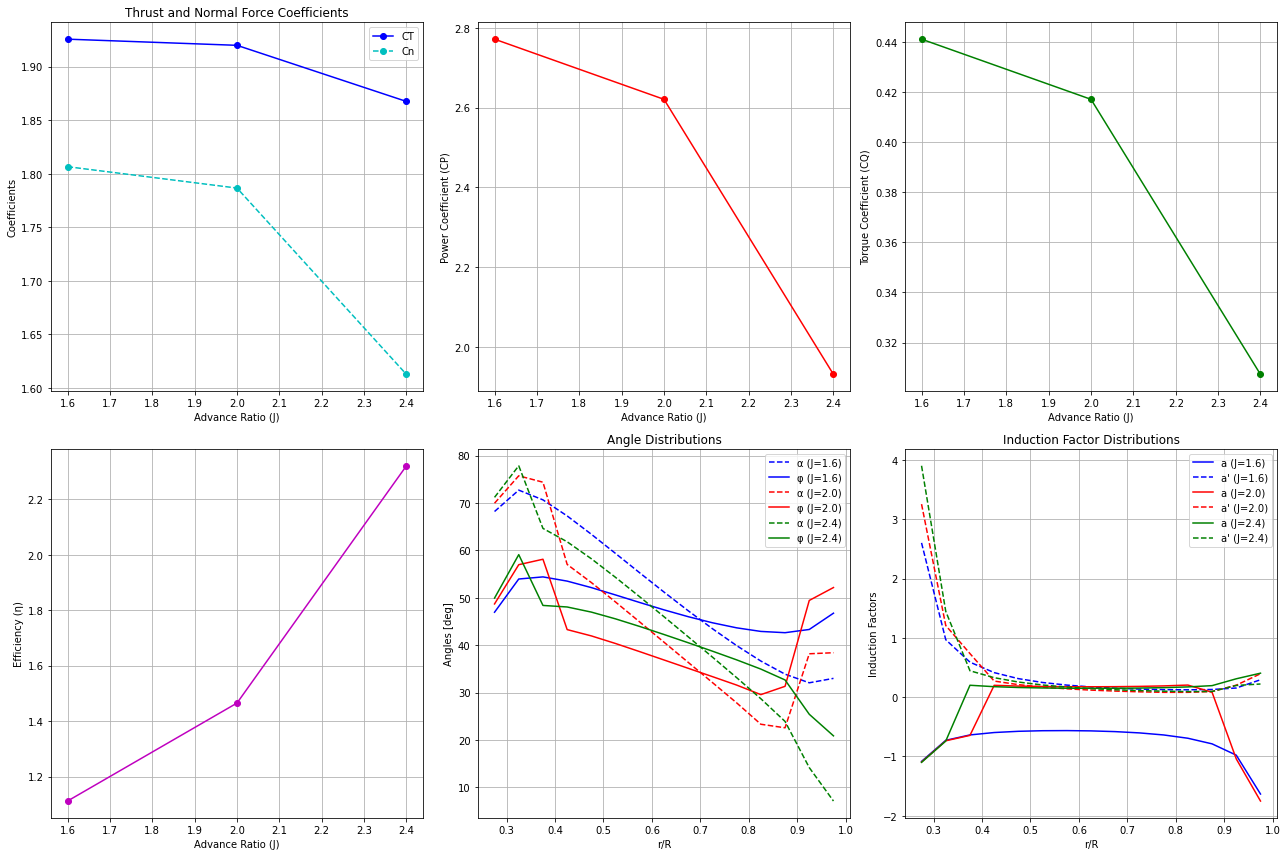

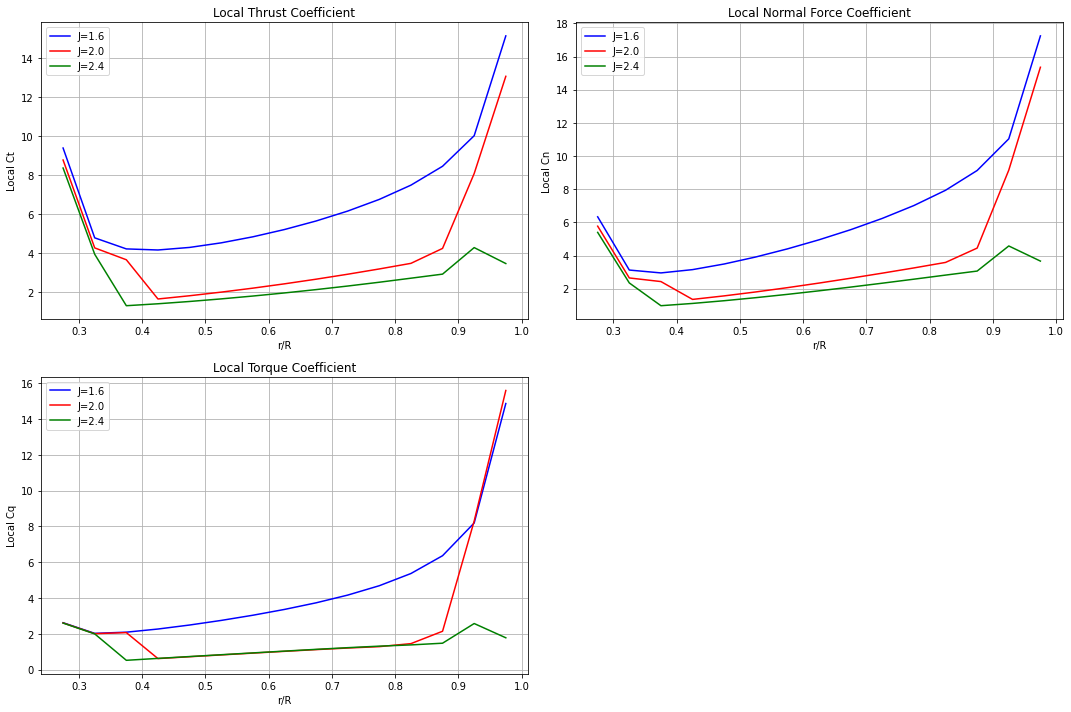

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters
RPM = 1200                # Constant rotational speed [rev/min]
Radius = 0.7              # Propeller radius [m]
D = 2 * Radius            # Propeller diameter [m]
rho = 1                   # Air density [kg/m³]
NBlades = 6               # Number of blades

# Blade geometry
delta_r_R = 0.05
hub_prop = 0.25
r_R = np.arange(hub_prop, 1 + delta_r_R/2, delta_r_R)
chord_distribution = 0.18 - 0.06 * r_R
twist_distribution = -50 * r_R + 35

# Target advance ratios
Js = np.array([1.6, 2.0, 2.4])
colors = ['b', 'r', 'g']  # Colors for different J values

# Initialize result storage
CTs = np.zeros_like(Js)
CPs = np.zeros_like(Js)
CQs = np.zeros_like(Js)
Cns = np.zeros_like(Js)  # Added Cn storage
effs = np.zeros_like(Js)

# Radial distribution storage
radial_positions = r_R[:-1] + delta_r_R/2  # Midpoints
radial_data = {
    'alpha': [],
    'inflow_angle': [],
    'a': [],
    'aline': [],
    'Ct_local': [],
    'Cn_local': [],
    'Cq_local': []
}

# Constant rotational parameters
n = RPM/60
Omega = (RPM/60) * 2 * np.pi

for idx, J in enumerate(Js):
    # Calculate corresponding freestream velocity
    Uinf = J * n * D
    
    # Solve BEM model
    results = np.zeros([len(r_R)-1, 7])
    element_data = {
        'alpha': [],
        'inflow_angle': [],
        'a': [],
        'aline': [],
        'Ct_local': [],
        'Cn_local': [],
        'Cq_local': []
    }
    
    for i in range(len(r_R)-1):
        chord = np.interp((r_R[i] + r_R[i+1])/2, r_R, chord_distribution)
        twist = np.interp((r_R[i] + r_R[i+1])/2, r_R, twist_distribution)
        
        # Get BEM solution
        a, aline, r_mid, fnorm, ftan, gamma, blade_normal = solveStreamtube(
            Uinf, r_R[i], r_R[i+1], hub_prop, 1, Omega, Radius,
            NBlades, chord, twist, polar_alpha, polar_cl, polar_cd
        )
        
        # Store element data
        inflow_angle = np.arctan2(Uinf*(1-a), (1+aline)*Omega*r_mid*Radius)
        element_data['alpha'].append(twist + np.degrees(inflow_angle))
        element_data['inflow_angle'].append(np.degrees(inflow_angle))
        element_data['a'].append(a)
        element_data['aline'].append(aline)
        element_data['Ct_local'].append(fnorm/(0.5*rho*Uinf**2*chord))
        element_data['Cn_local'].append(blade_normal/(0.5*rho*Uinf**2*chord))
        element_data['Cq_local'].append(ftan*r_mid/(0.5*rho*Uinf**2*chord*Radius))
        
        results[i,:] = [a, aline, r_mid, fnorm, ftan, gamma, blade_normal]
    
    # Store radial data
    for key in radial_data:
        radial_data[key].append(element_data[key])
    
    # Calculate global coefficients
    dr = delta_r_R * Radius
    thrust = np.sum(results[:,3] * dr * NBlades)
    torque = np.sum(results[:,4] * results[:,2] * Radius * dr * NBlades)
    power = torque * Omega
    total_normal = np.sum(results[:,6] * dr * NBlades)
    
    # Your specified coefficient calculations
    CT = thrust / (rho * n**2 * D**4)
    CP = power / (rho * n**3 * D**5)
    CQ = torque / (rho * n**2 * D**5)
    Cn = total_normal / (rho * n**2 * D**4)  # Your Cn formula
    eta = (CT * J) / CP if CP != 0 else 0
    
    # Store results
    CTs[idx] = CT
    CPs[idx] = CP
    CQs[idx] = CQ
    Cns[idx] = Cn
    effs[idx] = eta

# Plotting
plt.figure(figsize=(18, 12))

# Global performance plots
plt.subplot(2, 3, 1)
plt.plot(Js, CTs, 'bo-', label='CT')
plt.plot(Js, Cns, 'co--', label='Cn')
plt.xlabel('Advance Ratio (J)')
plt.ylabel('Coefficients')
plt.title('Thrust and Normal Force Coefficients')
plt.grid(True)
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(Js, CPs, 'ro-')
plt.xlabel('Advance Ratio (J)')
plt.ylabel('Power Coefficient (CP)')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(Js, CQs, 'go-')
plt.xlabel('Advance Ratio (J)')
plt.ylabel('Torque Coefficient (CQ)')
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(Js, effs, 'mo-')
plt.xlabel('Advance Ratio (J)')
plt.ylabel('Efficiency (η)')
plt.grid(True)

# Radial distributions
plt.subplot(2, 3, 5)
for j, J in enumerate(Js):
    plt.plot(radial_positions, radial_data['alpha'][j], colors[j]+'--', label=f'α (J={J})')
    plt.plot(radial_positions, radial_data['inflow_angle'][j], colors[j]+'-', label=f'φ (J={J})')
plt.xlabel('r/R')
plt.ylabel('Angles [deg]')
plt.title('Angle Distributions')
plt.grid(True)
plt.legend()

plt.subplot(2, 3, 6)
for j, J in enumerate(Js):
    plt.plot(radial_positions, radial_data['a'][j], colors[j]+'-', label=f'a (J={J})')
    plt.plot(radial_positions, radial_data['aline'][j], colors[j]+'--', label=f"a' (J={J})")
plt.xlabel('r/R')
plt.ylabel('Induction Factors')
plt.title('Induction Factor Distributions')
plt.grid(True)
plt.legend()

plt.tight_layout()

# Local coefficient distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for j, J in enumerate(Js):
    plt.plot(radial_positions, radial_data['Ct_local'][j], colors[j]+'-', label=f'J={J}')
plt.xlabel('r/R')
plt.ylabel('Local Ct')
plt.title('Local Thrust Coefficient')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
for j, J in enumerate(Js):
    plt.plot(radial_positions, radial_data['Cn_local'][j], colors[j]+'-', label=f'J={J}')
plt.xlabel('r/R')
plt.ylabel('Local Cn')
plt.title('Local Normal Force Coefficient')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
for j, J in enumerate(Js):
    plt.plot(radial_positions, radial_data['Cq_local'][j], colors[j]+'-', label=f'J={J}')
plt.xlabel('r/R')
plt.ylabel('Local Cq')
plt.title('Local Torque Coefficient')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

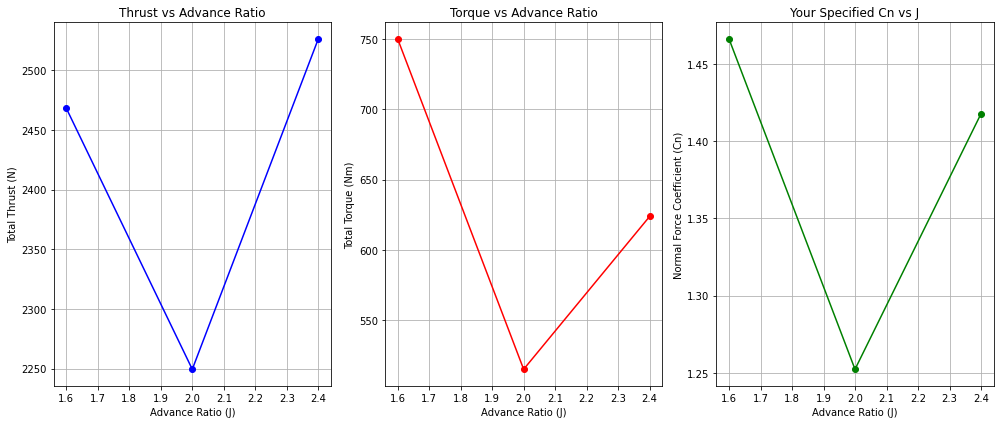

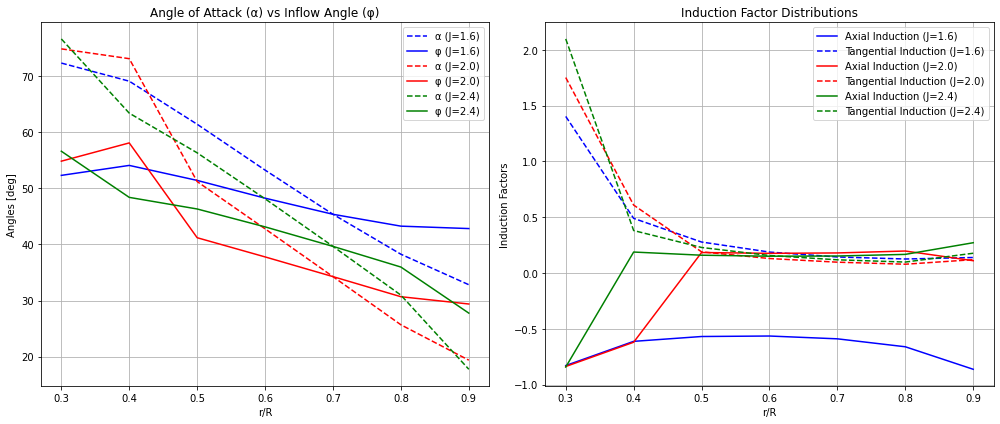

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters
RPM = 1200                # Constant rotational speed [rev/min]
Radius = 0.7              # Propeller radius [m]
D = 2 * Radius            # Propeller diameter [m]
rho = 1                   # Air density [kg/m³]
NBlades = 6               # Number of blades

# Blade geometry
delta_r_R = 0.1 
hub_prop = 0.25
r_R = np.arange(hub_prop, 1 + delta_r_R/2, delta_r_R)
chord_distribution = 0.18 - 0.06 * r_R
twist_distribution = -50 * r_R + 35

# Target advance ratios
Js = np.array([1.6, 2.0, 2.4])
colors = ['b', 'r', 'g']  # Colors for different J values

# Initialize result storage
thrusts = np.zeros_like(Js)
torques = np.zeros_like(Js)
TSRs = np.zeros_like(Js)  # Tip-speed ratios
Cns = np.zeros_like(Js)   # Your specified Cn

# Radial distribution storage
radial_positions = r_R[:-1] + delta_r_R/2
radial_data = {
    'alpha': [],
    'inflow_angle': [],
    'a': [],
    'aline': [],
    'Ct_local': [],
    'Cn_local': [],
    'Cq_local': []
}

# Constant rotational parameters
n = RPM/60
Omega = (RPM/60) * 2 * np.pi

for idx, J in enumerate(Js):
    # Calculate corresponding freestream velocity
    Uinf = J * n * D
    TSR = (Omega * Radius) / Uinf  # Calculate actual TSR
    TSRs[idx] = TSR
    
    # Solve BEM model
    results = np.zeros([len(r_R)-1, 7])
    element_data = {
        'alpha': [],
        'inflow_angle': [],
        'a': [],
        'aline': [],
        'Ct_local': [],
        'Cn_local': [],
        'Cq_local': []
    }
    
    for i in range(len(r_R)-1):
        chord = np.interp((r_R[i] + r_R[i+1])/2, r_R, chord_distribution)
        twist = np.interp((r_R[i] + r_R[i+1])/2, r_R, twist_distribution)
        
        # Get BEM solution
        a, aline, r_mid, fnorm, ftan, gamma, blade_normal = solveStreamtube(
            Uinf, r_R[i], r_R[i+1], hub_prop, 1, Omega, Radius,
            NBlades, chord, twist, polar_alpha, polar_cl, polar_cd
        )
        
        # Store element data
        inflow_angle = np.arctan2(Uinf*(1-a), (1+aline)*Omega*r_mid*Radius)
        element_data['alpha'].append(twist + np.degrees(inflow_angle))
        element_data['inflow_angle'].append(np.degrees(inflow_angle))
        element_data['a'].append(a)
        element_data['aline'].append(aline)
        element_data['Ct_local'].append(fnorm/(0.5*rho*Uinf**2*chord))
        element_data['Cn_local'].append(blade_normal/(0.5*rho*Uinf**2*chord))
        element_data['Cq_local'].append(ftan*r_mid/(0.5*rho*Uinf**2*chord*Radius))
        
        results[i,:] = [a, aline, r_mid, fnorm, ftan, gamma, blade_normal]
    
    # Store radial data
    for key in radial_data:
        radial_data[key].append(element_data[key])
    
    # Calculate global parameters
    dr = delta_r_R * Radius
    thrust = np.sum(results[:,3] * dr * NBlades)
    torque = np.sum(results[:,4] * results[:,2] * Radius * dr * NBlades)
    total_normal = np.sum(results[:,6] * dr * NBlades)
    
    # Store dimensional values
    thrusts[idx] = thrust
    torques[idx] = torque
    
    # Your specified Cn calculation
    Cns[idx] = total_normal / (rho * n**2 * D**4)

# Performance vs Advance Ratio Plots
plt.figure(figsize=(14, 6))

# Thrust vs J
plt.subplot(1, 3, 1)
plt.plot(Js, thrusts, 'bo-')
plt.xlabel('Advance Ratio (J)')
plt.ylabel('Total Thrust (N)')
plt.grid(True)
plt.title('Thrust vs Advance Ratio')

# Torque vs J
plt.subplot(1, 3, 2)
plt.plot(Js, torques, 'ro-')
plt.xlabel('Advance Ratio (J)')
plt.ylabel('Total Torque (Nm)')
plt.grid(True)
plt.title('Torque vs Advance Ratio')

# Cn vs J
plt.subplot(1, 3, 3)
plt.plot(Js, Cns, 'go-')
plt.xlabel('Advance Ratio (J)')
plt.ylabel('Normal Force Coefficient (Cn)')
plt.grid(True)
plt.title('Your Specified Cn vs J')

plt.tight_layout()

# Angle and Induction Factor Distributions
plt.figure(figsize=(14, 6))

# Angles plot
plt.subplot(1, 2, 1)
for j, J in enumerate(Js):
    plt.plot(radial_positions, radial_data['alpha'][j], colors[j]+'--', 
             label=f'α (J={J})')
    plt.plot(radial_positions, radial_data['inflow_angle'][j], colors[j]+'-', 
             label=f'φ (J={J})')
plt.xlabel('r/R')
plt.ylabel('Angles [deg]')
plt.title('Angle of Attack (α) vs Inflow Angle (φ)')
plt.grid(True)
plt.legend()

# Induction factors plot
plt.subplot(1, 2, 2)
for j, J in enumerate(Js):
    plt.plot(radial_positions, radial_data['a'][j], colors[j]+'-', 
             label=f'Axial Induction (J={J})')
    plt.plot(radial_positions, radial_data['aline'][j], colors[j]+'--', 
             label=f"Tangential Induction (J={J})")
plt.xlabel('r/R')
plt.ylabel('Induction Factors')
plt.title('Induction Factor Distributions')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

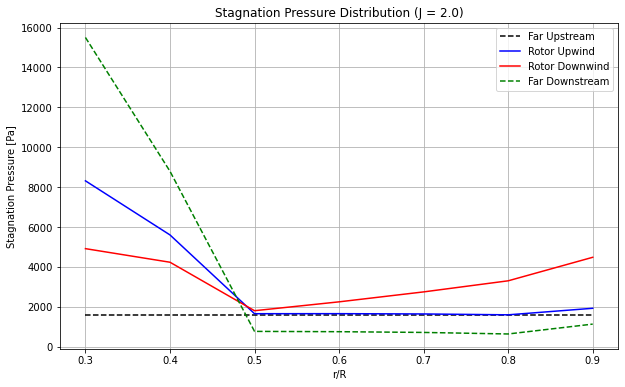

In [114]:
# Fixed parameters for J=2
J = 2.0
Uinf = J * n * D
results = []
radial_positions = []

# Additional storage for pressure calculations
p0_inf_up = []
p0_rotor_up = []
p0_rotor_down = []
p0_inf_down = []

for i in range(len(r_R)-1):
    chord = np.interp((r_R[i] + r_R[i+1])/2, r_R, chord_distribution)
    twist = np.interp((r_R[i] + r_R[i+1])/2, r_R, twist_distribution)
    
    # Get BEM solution
    a, aline, r_mid, fnorm, ftan, gamma, blade_normal = solveStreamtube(
        Uinf, r_R[i], r_R[i+1], hub_prop, 1, Omega, Radius,
        NBlades, chord, twist, polar_alpha, polar_cl, polar_cd
    )
    
    # Element calculations
    dr = delta_r_R * Radius
    r_actual = r_mid * Radius
    dT = fnorm * dr * NBlades  # Thrust contribution from this element
    
    # Pressure jump across rotor (actuator disk theory)
    dp = dT / (2 * np.pi * r_actual * dr)  # [Pa]
    
    # Static pressures (gauge)
    p_up = dp/2
    p_down = -dp/2
    
    # Velocities
    V_axial_rotor = Uinf * (1 - a)
    V_tangential_rotor = Omega * r_actual * (1 + aline)
    V_axial_far = Uinf * (1 - 2*a)
    V_tangential_far = 2 * Omega * r_actual * aline  # Fully developed swirl
    
    # Stagnation pressures
    p0_inf_up.append(0.5 * rho * Uinf**2)  # Far upstream
    p0_rotor_up.append(p_up + 0.5 * rho * V_axial_rotor**2)
    p0_rotor_down.append(p_down + 0.5 * rho * (V_axial_rotor**2 + V_tangential_rotor**2))
    p0_inf_down.append(0.5 * rho * (V_axial_far**2 + V_tangential_far**2))
    
    radial_positions.append(r_mid)

# Convert to arrays
radial_positions = np.array(radial_positions)
p0_inf_up = np.array(p0_inf_up)
p0_rotor_up = np.array(p0_rotor_up)
p0_rotor_down = np.array(p0_rotor_down)
p0_inf_down = np.array(p0_inf_down)

plt.figure(figsize=(10, 6))
plt.plot(radial_positions, p0_inf_up, 'k--', label='Far Upstream')
plt.plot(radial_positions, p0_rotor_up, 'b-', label='Rotor Upwind')
plt.plot(radial_positions, p0_rotor_down, 'r-', label='Rotor Downwind')
plt.plot(radial_positions, p0_inf_down, 'g--', label='Far Downstream')

plt.xlabel('r/R')
plt.ylabel('Stagnation Pressure [Pa]')
plt.title(f'Stagnation Pressure Distribution (J = {J})')
plt.grid(True)
plt.legend()
plt.show()

<ipython-input-100-1dff5ec040d3>:9: RuntimeWarning: invalid value encountered in sqrt
  return 0.5 * (np.sqrt(1 + CT) - 1) if CT <= 1 else -0.5


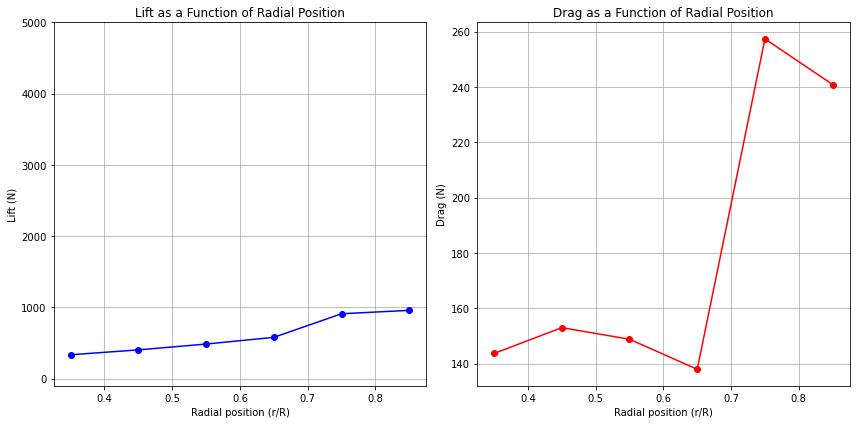

In [115]:
# Initialize lists to store lift and drag values
lift_values = []
drag_values = []

# Calculate the lift and drag for each blade element
for r_R_value in r_R:
    results = solveStreamtube(Uinf, r_R_value, r_R_value + delta_r_R, 0.3, 1, Omega, 0.7, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd)
    fnorm, ftan, gamma, blade_normal_force = results[3], results[4], results[5], results[6]
    
    # Calculate the lift and drag at this blade element (from fnorm and ftan)
    lift = fnorm * np.cos(np.radians(twist)) - ftan * np.sin(np.radians(twist))
    drag = fnorm * np.sin(np.radians(twist)) + ftan * np.cos(np.radians(twist))
    
    lift_values.append(lift)
    drag_values.append(drag)

# Plotting the Lift vs Radial Position
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(r_R, lift_values, label="Lift", color="blue", marker="o")
plt.xlabel("Radial position (r/R)")
plt.ylabel("Lift (N)")
plt.title("Lift as a Function of Radial Position")
plt.ylim(-100,5000)
plt.grid(True)

# Plotting the Drag vs Radial Position
plt.subplot(1, 2, 2)
plt.plot(r_R, drag_values, label="Drag", color="red", marker="o")
plt.xlabel("Radial position (r/R)")
plt.ylabel("Drag (N)")
plt.title("Drag as a Function of Radial Position")
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [116]:
rho

1